In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from auxiliary import get_base_network_name

net_dir = '../networks/ER'

In [114]:
def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

attack = 'Deg'
meank = 5
N_values = [250, 500, 1000, 2000, 4000, 8000, 16000]
compare_fast = False
if compare_fast:
    dfs = {}
    for N in N_values:
        df = load_dataframe(attack, N, meank)
        dfs[N] = df

    fast_dfs = {}
    for N in N_values:
        df = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        fast_dfs[N] = df
        
else:
    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    for N in N_values:
        dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        #dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)

FileNotFoundError: [Errno 2] File b'../networks/ER/ER_k5.00/ER_k5.00_N16000/Deg_nSeeds1000_cpp.csv' does not exist: b'../networks/ER/ER_k5.00/ER_k5.00_N16000/Deg_nSeeds1000_cpp.csv'

KeyError: 4000

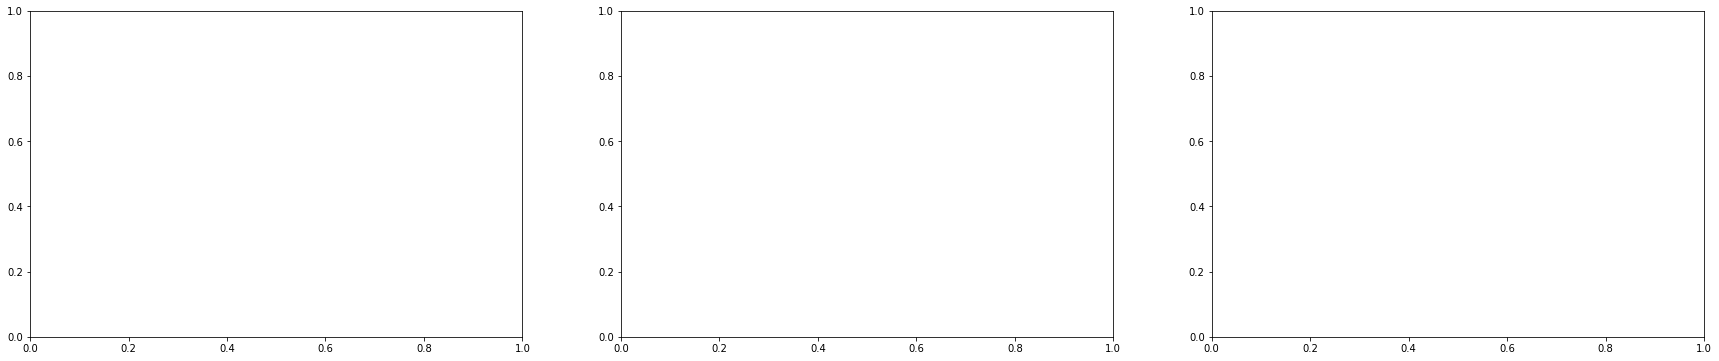

In [81]:
ncols = 3
fig, axes = plt.subplots(figsize=(10*ncols, 6), ncols=ncols)

ax = axes[0]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.Nsec)
ax.set_xlim(0.65, 0.85)
ax.set_ylim(5, 11)

ax = axes[1]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.meanS)
ax.set_xlim(0.65, 0.85)
ax.set_ylim(2, 4)

ax = axes[2]
for df in [dfs[N], fast_dfs[N]]:
    ax.plot(df.f, df.varSgcc)
ax.set_xlim(0.65, 0.85)
#ax.set_ylim(2, 4)

plt.show()

In [42]:
S1_over_S2_values = {}
for N in N_values:
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S1_over_S2_values[N] = S1_over_S2

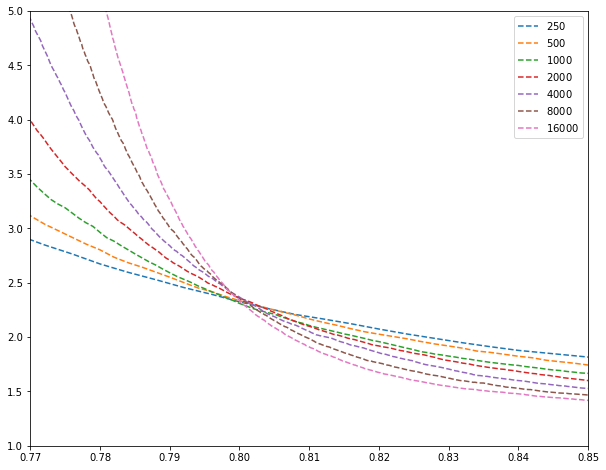

In [108]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_xlim(0.79, 0.81)
ax.set_xlim(0.77, 0.85)
#ax.set_ylim(2.1, 2.6)
ax.set_ylim(1, 5)
for i, N in enumerate(N_values):

    #df = dfs1000[N]
    #S1_over_S2 = N * df.Sgcc / df.Nsec
    #ax.plot(df.f, S1_over_S2, ':', color=colors[i])
    
    df = dfs10000[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    ax.plot(df.f, S1_over_S2, '--', label=r'${{{}}}$'.format(N), color=colors[i])
    
    #df = dfs20000[N]
    #S1_over_S2 = N * df.Sgcc / df.Nsec
    #ax.plot(df.f, S1_over_S2, '-', color=colors[i])
    
#ax.axvline(0.8, linestyle='--', color='k')
ax.legend(loc='best')
plt.show()

In [112]:
def compute_fc_v2(dfs, min_f, max_f):

    N_values = sorted(list(dfs.keys()))
    
    
    N1_over_N2 = {}
    for N in N_values:
        N1_over_N2[N] = ((N*dfs[N]['Sgcc'])/dfs[N]['Nsec']).values

    max_N = N_values[-1]
    mask = np.arange(int(min_f*max_N), int(max_f*max_N))
    n_values = len(mask)
    x = dfs[max_N]['f'][mask].values
    inter_values = []
    s = np.zeros(n_values)
    for Na in N_values:
        for Nb in N_values:
            if Nb <= Na:
                continue
            mask = np.arange(int(min_f*Na), int(max_f*Na))
            xp = dfs[Na]['f'][mask].values
            fp = N1_over_N2[Na][mask]
            Na_values = np.interp(x, xp, fp)

            mask = np.arange(int(min_f*Nb), int(max_f*Nb))
            xp = dfs[Nb]['f'][mask].values
            fp = N1_over_N2[Nb][mask]
            Nb_values = np.interp(x, xp, fp)
            s += np.fabs(1 - Na_values/Nb_values)
            inter = np.argmin(s)/max_N
            inter_values.append(inter)
    mean_inter = np.mean(inter_values)
    std_inter = np.std(inter_values)
    fc = min_f + mean_inter
    return fc, std_inter

fmin = 0.7
fmax = 0.9
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs1000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs10000, fmin, fmax)))
print('{:.4f} {:.4f}'.format(*compute_fc_v2(dfs20000, fmin, fmax)))

0.8006 0.0012
0.8011 0.0012
0.8005 0.0011
